In [2]:
# !pip install --no-cache-dir git+https://github.com/averinpa/bnm.git@feature/sid-metric

In [2]:
from bnm import BNMetrics, generate_random_dag, dag_to_cpdag, generate_synthetic_data_from_dag
import networkx as nx
import pandas as pd
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from bnm.utils import graph_to_matrix

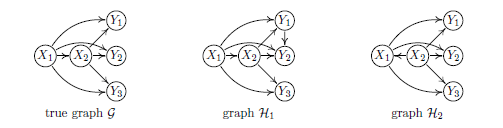

In [2]:
nodes = ['X1', 'X2', 'Y1', 'Y2', 'Y3']

G = np.array([[0, 1, 1, 1, 1], 
             [0, 0, 1, 1, 1], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0]])

H1 = np.array([[0, 1, 1, 1, 1], 
             [0, 0, 1, 1, 1], 
             [0, 0, 0, 1, 0], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0]])

H2 = np.array([[0, 0, 1, 1, 1], 
             [1, 0, 1, 1, 1], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0]])

In [3]:
bnm = BNMetrics(G, H1, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='G', name2='H1')
print((bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'})))
print('\nSID Incorect Interventional distributions')
print(bnm.sid(nodes=['All'], output=False)['incorrect_mat'])

            metric metric_value
0              shd            1
1              sid          0.0
2  sid_lower_bound          0.0
3  sid_upper_bound          0.0

SID Incorect Interventional distributions
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [4]:
bnm = BNMetrics(G, H2, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='G', name2='H2')
print((bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'})))
print('\nSID Incorect Interventional distributions')
print(bnm.sid(nodes=['All'], output=False)['incorrect_mat'])

            metric metric_value
0              shd            1
1              sid          8.0
2  sid_lower_bound          8.0
3  sid_upper_bound          8.0

SID Incorect Interventional distributions
[[0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [5]:
nodes = ['X1', 'X2', 'X3', 'X4']

DAG = np.array([[0, 0, 0, 0], 
                [0, 0, 1, 0], 
                [1, 0, 0, 0], 
                [1, 0, 1, 0]])

DAG1 = np.array([[0, 1, 0, 0], 
                 [0, 0, 1, 0], 
                 [0, 0, 0, 0], 
                 [0, 0, 1, 0]])

DAG2 = np.array([[0, 0, 0, 0], 
                 [1, 0, 1, 0], 
                 [0, 0, 0, 0], 
                 [0, 0, 1, 0]])

CPDAG = np.array([[0, 1, 0, 0], 
                  [1, 0, 1, 0], 
                  [0, 0, 0, 0], 
                  [0, 0, 1, 0]])

In [6]:
bnm = BNMetrics(DAG, DAG1, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='True DAG', name2='Estimated DAG 1')
print((bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'})))
print('\nSID Incorect Interventional distributions')
print(bnm.sid(nodes=['All'], output=False)['incorrect_mat'])



bnm = BNMetrics(DAG, DAG2, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='DAG', name2='Estimated DAG 2')
print((bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'})))
print('\nSID Incorect Interventional distributions')
print(bnm.sid(nodes=['All'], output=False)['incorrect_mat'])



bnm = BNMetrics(DAG, CPDAG, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='DAG', name2='Estimated CPDAG')
print((bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'})))
print('\nSID Incorect Interventional distributions')
print(bnm.sid(nodes=['All'], output=False)['incorrect_mat'])

            metric metric_value
0              shd            3
1              sid          6.0
2  sid_lower_bound          6.0
3  sid_upper_bound          6.0

SID Incorect Interventional distributions
[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


            metric metric_value
0              shd            3
1              sid          2.0
2  sid_lower_bound          2.0
3  sid_upper_bound          2.0

SID Incorect Interventional distributions
[[0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


            metric metric_value
0              shd            3
1              sid          6.0
2  sid_lower_bound          2.0
3  sid_upper_bound          6.0

SID Incorect Interventional distributions
[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Structure learning

In [3]:
true_dag = generate_random_dag(n_nodes=40, edge_prob=0.1, seed=55)
data = generate_synthetic_data_from_dag(true_dag, n_samples=1000, stdev=1.0, seed=55)
data = data[list(true_dag.nodes)]

In [4]:
cg = pc(data.values)

  0%|          | 0/40 [00:00<?, ?it/s]

In [5]:
cg.to_nx_graph()
nx.to_numpy_array(cg.nx_graph).shape

(40, 40)

In [6]:
bn_obj = BNMetrics(G1=true_dag, G2=nx.to_numpy_array(cg.nx_graph), mb_nodes=['X_33'])

In [7]:
mat = bn_obj.sid(nodes=['X_33'], output=False)['incorrect_mat']

In [8]:
labels = list(bn_obj.graph_dict['X_33']['d1'].nodes())

In [9]:
mat

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [12]:
mat.shape

(15, 15)

In [18]:
mat

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

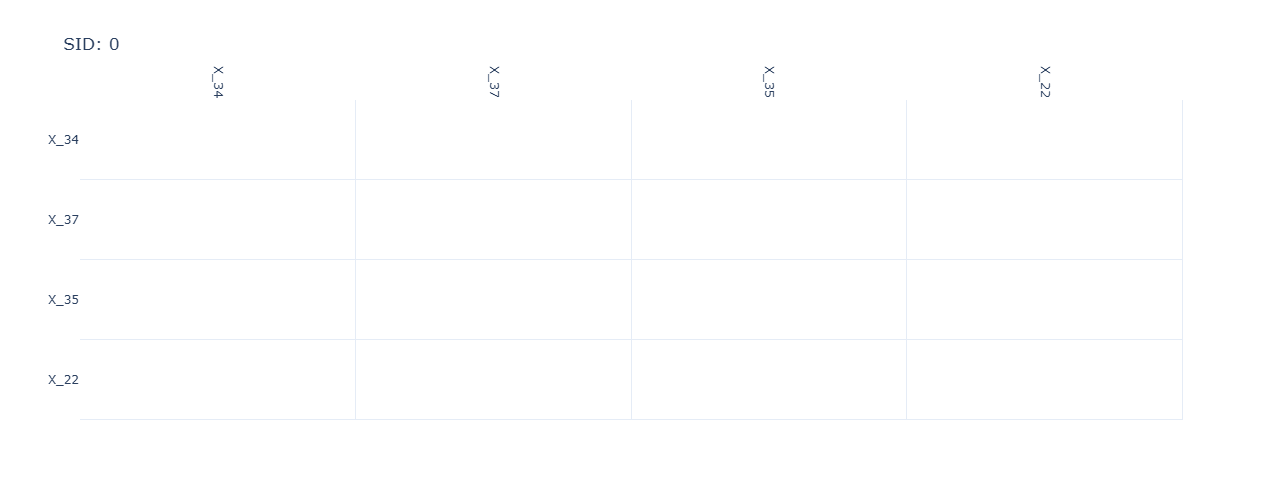

In [22]:
bn_obj = BNMetrics(G1=true_dag, G2=nx.to_numpy_array(cg.nx_graph))
mat = bn_obj.sid(nodes=['X_22'], output=False)['incorrect_mat']
sid = bn_obj.sid(nodes=['X_22'], output=False)['sid']
labels = list(bn_obj.graph_dict['X_22']['d1'].nodes())
black_white_scale = [[0.0, 'white'], [0.9999, 'white'], [1.0, 'crimson']]
# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=mat,
    x=labels,
    y=labels,
    showscale=False,
    xgap=1,           # Add gaps to simulate grid
    ygap=1,
    colorscale=black_white_scale,
    zmin=0,
    zmax=1,# or 'Blues', 'Hot', etc.
))

fig.update_layout(
    title=f"SID: {int(sid)}",
    xaxis=dict(showgrid=False, tickangle=90, side='top'),
    yaxis=dict(showgrid=False, autorange='reversed'),
    width=500,   # adjust width in pixels
    height=500   # adjust height in pixels
)
fig.show()


In [50]:
graph_to_matrix(bn_obj.graph_dict['X_33']['d1'])

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]),
 ['X_38',
  'X_2',
  'X_20',
  'X_19',
  'X_35',
  'X_15',
  'X_11',
  'X_4',
  'X_21',
  'X_40',
  'X_33',
  'X_29'])

In [51]:
graph_to_matrix(bn_obj.graph_dict['X_33']['d3'])

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]),
 ['X_38',
  'X_2',
  'X_20',
  'X_19',
  'X_35',
  'X_15',
  'X_11',
  'X_4',
  'X_21',
  'X_40',
  'X_33',
  'X_29'])

In [47]:
bn_obj.compare_two_bn(nodes=['X_33'], option=2)